# Ruled-based Model

In this notebook, we elucidate how we developed a rule-based model for recommendation of clothing pieces for commuting by bike.This notebook covers the following steps: 

1. Importing libraries
2. Generating input data and creating a dataframe
3. Daa pre-processing and exploratory data analysis
4. Model development 
5. Model evaluation
6. Model deployment
   
## 1. Importing libraries

In [35]:
import random
from random import randint
import requests, json
import pandas as pd
from datetime import datetime, timezone
import pytz # this lib allows accurate and cross platform timezone calculations with python
import numpy as np
#import config # to run this, you should have the congif file in the working directory
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Generating input data & collecting location/weather data from OpenWeatherMap API

In the first step of this section, we define a function 'input_generator' by assinging values to variables

In [3]:
def input_generator():
    location_list=('Atlanta','Berlin','Hamburg','München','Freiburg','Melbourne', 'Moskau') # example list 
    location=location_list[randint(0,6)]
    time=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)# timezone is irrelevant for our objectives
    time=time.replace(hour=randint(time.hour,23))
    heaviness_of_trip=randint(1,3)
    if heaviness_of_trip==1: heaviness_of_trip="easy"
    if heaviness_of_trip==2: heaviness_of_trip="normal"
    if heaviness_of_trip==3: heaviness_of_trip="hard"
    heat_preference=randint(-5,5)
    sex=randint(1,3)
    if sex==1: sex="m"
    if sex==2: sex="f"
    if sex==3: sex="d"
    df=pd.DataFrame({
    "location" : [location],
    "time": [time], 
    "heaviness_of_trip": [heaviness_of_trip], 
    "heat_preference" : [heat_preference],
    "sex": [sex]
    })
    return df

In [93]:
#testing if the function is working properly
print(input_generator().to_json())
input_generator()

{"location":{"0":"Moskau"},"time":{"0":1642968156194},"heaviness_of_trip":{"0":"hard"},"heat_preference":{"0":5},"sex":{"0":"f"}}


,location,time,heaviness_of_trip,heat_preference,sex
0,Atlanta,2022-01-23 23:02:36.195775,easy,-4,f


In the next step, we define a function to generate multiple input data by iterating over rows and appending input data into the dataframe.

In [15]:
#autogenerate DataFrame with multiple input
def generate_multi_input(a):
    df=input_generator()
    for t in range(a-1): #a Trips today (it is asking for one person, so the sex, the heat preference and the ocation ist not changing)
        df=df.append(input_generator(),ignore_index = True)
        df.at[t+1,'location']=df['location'].iloc[0]
        df.at[t+1,'heat_preference']=df['heat_preference'].iloc[0]
        df.at[t+1,'sex']=df['sex'].iloc[0]
    return df

In [21]:
#checking if the function is working as defined
a=generate_multi_input(4)
print(a)

    location                       time heaviness_of_trip  heat_preference sex
0  Melbourne 2022-01-31 23:16:48.979306            normal                2   m
1  Melbourne 2022-01-31 20:16:48.980868              hard                2   m
2  Melbourne 2022-01-31 21:16:48.986956              easy                2   m
3  Melbourne 2022-01-31 22:16:48.991970              easy                2   m


In [22]:
#displaying data in json
a=a.to_json(orient="index",date_format='iso')
print(a)

{"0":{"location":"Melbourne","time":"2022-01-31T23:16:48.979Z","heaviness_of_trip":"normal","heat_preference":2,"sex":"m"},"1":{"location":"Melbourne","time":"2022-01-31T20:16:48.980Z","heaviness_of_trip":"hard","heat_preference":2,"sex":"m"},"2":{"location":"Melbourne","time":"2022-01-31T21:16:48.986Z","heaviness_of_trip":"easy","heat_preference":2,"sex":"m"},"3":{"location":"Melbourne","time":"2022-01-31T22:16:48.991Z","heaviness_of_trip":"easy","heat_preference":2,"sex":"m"}}


In [23]:
#testing data with json input
json_inp=pd.read_json(a, orient='index',convert_dates=['time'])   
print(json_inp)

    location                             time heaviness_of_trip  \
0  Melbourne 2022-01-31 23:16:48.979000+00:00            normal   
1  Melbourne 2022-01-31 20:16:48.980000+00:00              hard   
2  Melbourne 2022-01-31 21:16:48.986000+00:00              easy   
3  Melbourne 2022-01-31 22:16:48.991000+00:00              easy   

   heat_preference sex  
0                2   m  
1                2   m  
2                2   m  
3                2   m  


In [96]:
b={"0":{"location":"Freiburg"},"1":{"time":"2022-01-23T23:09:32.856Z"},"2":{"location":"Freiburg","time":"2022-01-23T22:09:32.867Z","heaviness_of_trip":"easy","heat_preference":-2,"sex":"m"},"3":{"location":"Freiburg","time":"2022-01-23T17:09:32.878Z","heat_preference":-2,"sex":"m"}}
c=json.dumps(b)
print(c)
json_inp= pd.read_json(c, orient='index',convert_dates=['time'])   
print(json_inp)

{"0": {"location": "Freiburg"}, "1": {"time": "2022-01-23T23:09:32.856Z"}, "2": {"location": "Freiburg", "time": "2022-01-23T22:09:32.867Z", "heaviness_of_trip": "easy", "heat_preference": -2, "sex": "m"}, "3": {"location": "Freiburg", "time": "2022-01-23T17:09:32.878Z", "heat_preference": -2, "sex": "m"}}
   location                             time heaviness_of_trip  \
0  Freiburg                              NaT               NaN   
2  Freiburg 2022-01-23 22:09:32.867000+00:00              easy   
3  Freiburg 2022-01-23 17:09:32.878000+00:00               NaN   
1       NaN 2022-01-23 23:09:32.856000+00:00               NaN   

   heat_preference  sex  
0              NaN  NaN  
2             -2.0    m  
3             -2.0    m  
1              NaN  NaN  


In this step, we use python requests library to retrieve relevant data from the API. For this, we invoked the HTTP method Get to retrieve data.

In [27]:
def weather(df):
    base_url = "http://api.openweathermap.org/data/2.5/weather?" # assigning current weather url to base_url 
    future_url="https://api.openweathermap.org/data/2.5/forecast?"# assigning future weather url to future_url
    df['weather']=None
    df['temperature']=None
    #for every row in the dataframe
    for i in range(len(df.index)) :
        # Give city name
        city_name = df['location'].iloc[i]
        df_time=df['time'].iloc[i].replace(tzinfo=None)
        now=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)
        # complete_url stores the api address for the current weather data
        complete_current_url = base_url + "appid=" + config.api_key + "&q=" + city_name + "&units=metric"
        # complete url stores the api address for the future weather data
        complete_future_url = future_url + "q=" + city_name + "&appid=" + config.api_key + "&units=metric"
        # expected response object
        response = requests.get(complete_current_url).json() #response of the current weather data
        response_future = requests.get(complete_future_url).json() # response of the future weather (3 hours weather forecast)
        time_forecast=datetime.strptime(response_future['list'][0]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        time_forecast2=datetime.strptime(response_future['list'][1]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        # json method of response object
        # convert json format data into
        # python format data
        if (abs((df_time-now).total_seconds()) <abs((time_forecast-df_time).total_seconds()))&(abs((df_time-now).total_seconds()) <abs((time_forecast2-df_time).total_seconds())): #is the time closer to now then to any of the future forecast
            df.at[i,'weather']=response['weather'][0]['main']
            df.at[i,'temperature']=response['main']['temp']
            df.at[i,'windspeed']=response['wind']['speed']
        else:
            for a in range(10): # looks up to 30 hours in the future
                time_forecast=datetime.strptime(response_future['list'][a]['dt_txt'],'%Y-%m-%d %H:%M:%S')
                substrakt=time_forecast-df_time
                if abs(substrakt.total_seconds())<5400: ## Forecast is just every 3 hours, so it is always taking the closest one
                    df.at[i,'weather']=response_future['list'][a]['weather'][0]['main']
                    df.at[i,'temperature']=response_future['list'][a]['main']['temp']
                    df.at[i,'windspeed']=response_future['list'][a]['wind']['speed']
                    break   
    return df

In [28]:
#weather test
#two dataframes (one with just 1 input, and one with 6 input Trips)
test=weather(input_generator())
len(test.index)
test.to_json()
print(test.to_json())
print(test)
test2=weather(generate_multi_input(20))
test2.head()

<hr style="border:2px solid gray"> </hr>   
   
## 3. Data pre-processing and exploratory data analysis (EDA)

Data cleaning: The following function with for loop iterates over the rows in dataframe and detects missing values or inaccurate/corrupt records and replaces them with 'incomplete data' enabling the non-stop provision of data for the app.
1. if heat preference is missing --> 'incomplete data'
2. if sex is missing --> 'incomplete data'
3. if time is missing --> 'incomplete data'
4. if heavines of trip is missing --> 'incomplete data'
5. if location is missing --> 'incomplete data'

In [30]:
def input_cleaning(df):
    df['heat_preference'] = df['heat_preference'].fillna('incomplete data') 
    df['time'] = df['time'].fillna(datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None))
    df['sex'] = df['sex'].fillna('incomplete data')
    df['heaviness_of_trip'] = df['heaviness_of_trip'].fillna('incomplete data')
    df['location'] = df['location'].fillna('incomplete data')
    return df

In [31]:
input_cleaning(json_inp)
print(json_inp)

    location                             time heaviness_of_trip  \
0  Melbourne 2022-01-31 23:16:48.979000+00:00            normal   
1  Melbourne 2022-01-31 20:16:48.980000+00:00              hard   
2  Melbourne 2022-01-31 21:16:48.986000+00:00              easy   
3  Melbourne 2022-01-31 22:16:48.991000+00:00              easy   

   heat_preference sex  
0                2   m  
1                2   m  
2                2   m  
3                2   m  


Data visualisation

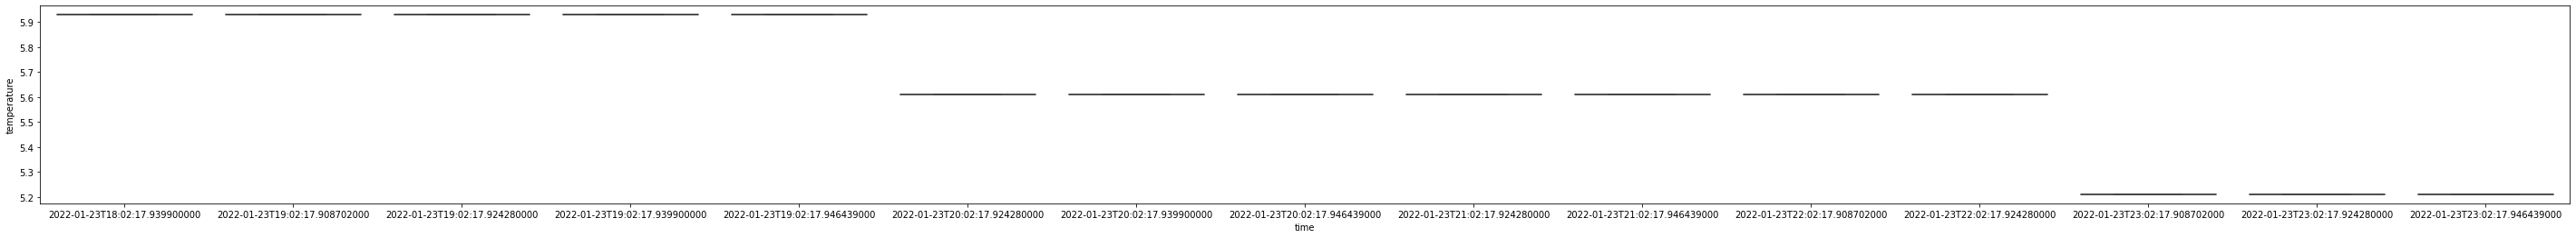

In [70]:
#plotting a box plot for all temperature data 
plt.figure(figsize=(50, 4))
a = sns.boxplot(x='time', y='temperature',data=test2.sort_values(by='time'))

Text(0.5, 1.0, 'Scatterplot')

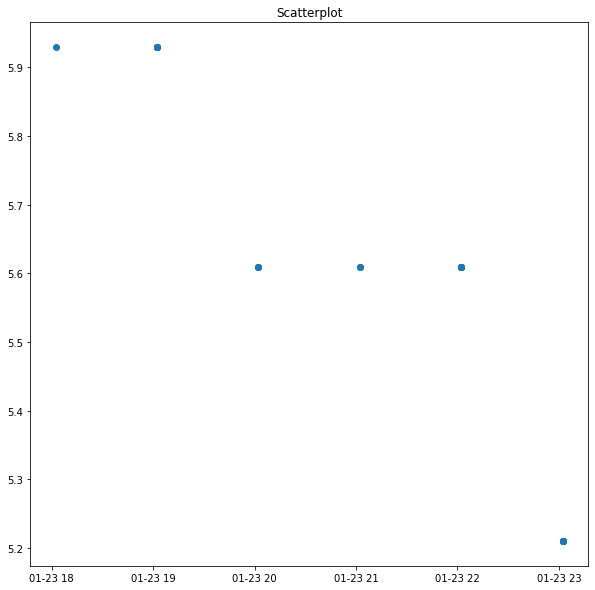

In [71]:
#plotting line chart to display data over time
# Max's comment, "scatter plot does not work with date information since it requires interval-scale data."
plt.figure(figsize=(10,10))
plt.scatter(x='time', y='temperature',data=test2.sort_values(by='time'))
plt.title("Scatterplot")

<hr style="border:2px solid gray"> </hr>   
   
## 5. Model development

In this section, we develop a model, based on the rules extracted from decision trees. The rules define the clothing items for different bodyparts based on five distinct features. We took the following arithmetic expression 'temp + heatperception – (if female ==2) > current_temp' as the main logic. The thresholds were picked based on empirical observation (personal experience) and intuition. All functions use dataframes as input and append new columns by extending the frame.

In [72]:
def t_p_s_h(df,i): # t_p_s_h stands for temperature_heat preference_sex_heaviness_of_trip
    red=0. # reducing parameter
    if df['sex'].iloc[i]=='f':
        red=2.
    heaviness=0.
    if df['heaviness_of_trip'].iloc[i]=='hard':
        heaviness=2.
    else:
        if df['heaviness_of_trip'].iloc[i]=='easy':
            heaviness=-2.
    t_p_s_h=float(df['temperature'].iloc[i])+float(df['heat_preference'].iloc[i])-red+heaviness
    return t_p_s_h

In [74]:
# defining the rules for headwear
def headwear(df):
   df['headwear']=3
   for i in range(len(df.index)):
      if t_p_s_h(df,i)>10: # if temp above 10C, the model recommends nothing but Helmet
            df.at[i,'headwear']=1
      else:
         if t_p_s_h(df,i)>2:
            df.at[i,'headwear']=2
   return df

In [75]:
# defining the rules for sunglasses
def sunglasses(df):
    df['sunglasses']=0
    for i in range(len(df.index)):
        if df['weather'].iloc[i]=='Clear': # sun or clear is the only split for this tree
            df.at[i,'sunglasses']=1
    return df

In [76]:
# defining the rules for neck
def neck(df):
    
    df['neck']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # above 22 degrees no buff
            df.at[i,'neck']=1
        else :
            if t_p_s_h(df,i)>15:
                if (df['weather'].iloc[i]=='Rain')|(df['windspeed'].iloc[i]>15): # if temp > 15C & windy or rainy, then buff, else none.
                    df.at[i,'neck']=2
                else :
                    df.at[i,'neck']=1
            else :
                if (t_p_s_h(df,i)>0) & (df['weather'].iloc[i]=='Clear'): # if temp > 0C & sunny, then buff, otherwise warm scarf
                    df.at[i,'neck']=2
    return df

In [77]:
# defining the rules for shirt and singlet 
def inner_layer(df):
    df['shirt']=0
    df['singlet']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>10: # 10 C is the split. If temp is above 10, wear shirt. Under 10C wear a singlet.
            df.at[i,'shirt']=1
        else:
            df.at[i,'singlet']=1
    
    return df

In [78]:
#defining the rules for the upper body clothing pieces
def upper_body_outer_layers(df):
    df['upper_body_second_layer']=3
    df['upper_body_third_layer']=3
    df['upper_body_outer_layer']=5
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>25:
            df.at[i,'upper_body_second_layer']=1
            df.at[i,'upper_body_third_layer']=1
            df.at[i,'upper_body_outer_layer']=1
        else:
            if t_p_s_h(df,i)>20:
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=3
                else:
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=1
            else:
                if t_p_s_h(df,i)>10:
                    if df['weather'].iloc[i]=='Rain':
                        df.at[i,'upper_body_second_layer']=3
                        df.at[i,'upper_body_third_layer']=1
                        df.at[i,'upper_body_outer_layer']=4
                    else:
                        df.at[i,'upper_body_second_layer']=2
                        df.at[i,'upper_body_third_layer']=2
                        df.at[i,'upper_body_outer_layer']=1
                else:
                    if t_p_s_h(df,i)>0:
                        if df['weather'].iloc[i]=='Clear':
                            df.at[i,'upper_body_second_layer']=2
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
                        else:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=1
                            df.at[i,'upper_body_outer_layer']=5
                    else:
                        if t_p_s_h(df,i)>-5:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
    return df

In [79]:
#defining the rules for handwear
def hands(df):
    df['hands']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>10: # first split is at 10 C, model recommends no handwear.
            df.at[i,'hands']=1
        else:
            if (t_p_s_h(df,i)>7):
                if(df['windspeed'].iloc[i]>15):
                    df.at[i,'hands']=2
                else:
                    df.at[i,'hands']=1
            else:
                if (t_p_s_h(df,i)>0):
                    df.at[i,'hands']=2
    return df

In [80]:
# defining the rules for raintrousers
def raintrousers(df):
    df['raintrousers']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)<17: # 17C is the first split. If temp < 17 and rainy, it recommends raintrousers.
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'raintrousers']=1
    return df

In [81]:
# defining the rules for socks
def socks(df):
    df['socks']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22: # if temp > 22 and rainy, the model recommends socks
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'socks']=2
            else:
                if df['sex'].iloc[i]=='f': # if temp > 22, weather state is not rainy & user is female, then no socks, for male with socks
                    df.at[i,'socks']=1
                else:
                    df.at[i,'socks']=2
        else:
            if t_p_s_h(df,i)>0:       # above 0 normal socks, under 0 woolen socks
                df.at[i,'socks']=2
    return df

In [82]:
#defining the rules for shoes
def shoes(df):
    df['shoes']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # if the temp > 22 C & rainy, the model recommends low shoes
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'shoes']=2
            else:
                    df.at[i,'shoes']=1 # if temp > 22, the model recommends summer shoes
        else:
            if t_p_s_h(df,i)>7: # if temp > 7 & rainy, the model recommends rainshoes
                    df.at[i,'shoes']=4 # if not rainy, then normal shoes. if under 7 C, then boots
                if df['weather'].iloc[i]=='Rain':
                else:
                    df.at[i,'shoes']=2

    return df

In [83]:
# concatenating the output of the logic of the decision trees into single list
def get_clothing_output_rbm(df):
    headwear(df)
    sunglasses(df)
    neck(df)
    inner_layer(df)
    upper_body_outer_layers(df)
    hands(df)
    raintrousers(df)
    socks(df)
    shoes(df)
    #df['control']=0
    #for i in range(len(df.index)):
    #   df.at[i,'control']=t_p_s_h(df,i)
    return df

In [73]:
# using function 'add_dummy(df)'for testing purposes.<p>
def add_dummy(df):
    df['headwear']=1
    df['sunglasses']=0
    df['neck']=1
    df['singlet']=0
    df['shirt']=0
    df['upper_body_second_layer']=1
    df['upper_body_third_layer']=1
    df['upper_body_outer_layer']=1
    df['hands']=1
    df['raintrousers']=0
    df['socks']=1
    df['shoes']=1
    for i in range(len(df.index)):
        df.at[i,'headwear']=randint(1,4)
        df.at[i,'sunglasses']=randint(0,1)
        df.at[i,'neck']=randint(1,3)
        df.at[i,'singlet']=randint(0,1)
        df.at[i,'shirt']=randint(0,1)
        df.at[i,'upper_body_second_layer']=randint(1,3)
        df.at[i,'upper_body_third_layer']=randint(1,3)
        df.at[i,'upper_body_outer_layer']=randint(1,5)
        df.at[i,'hands']=randint(1,3)
        df.at[i,'raintrousers']=randint(0,1)
        df.at[i,'socks']=randint(1,2)
        df.at[i,'shoes']=randint(1,3)
    return df

In [84]:
#testing the model
test3=weather(generate_multi_input(20))
get_clothing_output_rbm(test3)

,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed,headwear,sunglasses,neck,shirt,singlet,upper_body_second_layer,upper_body_third_layer,upper_body_outer_layer,hands,raintrousers,socks,shoes
0,Melbourne,2022-01-23 22:02:24.670944,normal,5,d,Clouds,14.48,4.26,1,0,1,1,0,2,2,1,1,0,2,2
1,Melbourne,2022-01-23 21:02:24.671942,easy,5,d,Clouds,14.48,4.26,1,0,1,1,0,2,2,1,1,0,2,2
2,Melbourne,2022-01-23 19:02:24.676928,hard,5,d,Clouds,12.65,5.14,1,0,1,1,0,2,2,1,1,0,2,2
3,Melbourne,2022-01-23 19:02:24.681915,easy,5,d,Clouds,12.65,5.14,1,0,1,1,0,2,2,1,1,0,2,2
4,Melbourne,2022-01-23 20:02:24.683910,easy,5,d,Clouds,14.48,4.26,1,0,1,1,0,2,2,1,1,0,2,2
5,Melbourne,2022-01-23 21:02:24.686903,normal,5,d,Clouds,14.48,4.26,1,0,1,1,0,2,2,1,1,0,2,2
6,Melbourne,2022-01-23 23:02:24.691889,normal,5,d,Clouds,13.73,4.50,1,0,1,1,0,2,2,1,1,0,2,2
7,Melbourne,2022-01-23 19:02:24.695886,normal,5,d,Clouds,12.65,5.14,1,0,1,1,0,2,2,1,1,0,2,2
8,Melbourne,2022-01-23 21:02:24.699869,hard,5,d,Clouds,14.48,4.26,1,0,1,1,0,2,1,1,1,0,2,2
9,Melbourne,2022-01-23 23:02:24.702899,normal,5,d,Clouds,13.73,4.50,1,0,1,1,0,2,2,1,1,0,2,2


In [85]:
add_dummy(test2)

,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed,headwear,sunglasses,neck,singlet,shirt,upper_body_second_layer,upper_body_third_layer,upper_body_outer_layer,hands,raintrousers,socks,shoes
0,Berlin,2022-01-23 22:02:17.908702,normal,1,d,Clouds,5.61,1.64,2,0,2,0,0,1,3,4,3,0,2,2
1,Berlin,2022-01-23 23:02:17.908702,hard,1,d,Clouds,5.21,1.48,4,0,3,1,0,3,2,1,2,1,2,3
2,Berlin,2022-01-23 19:02:17.908702,hard,1,d,Drizzle,5.93,2.68,1,0,1,1,1,3,2,3,3,1,2,1
3,Berlin,2022-01-23 21:02:17.924280,easy,1,d,Clouds,5.61,1.64,3,1,1,0,1,2,2,5,3,1,1,3
4,Berlin,2022-01-23 20:02:17.924280,easy,1,d,Clouds,5.61,1.64,4,1,1,0,0,2,3,3,3,0,1,3
5,Berlin,2022-01-23 19:02:17.924280,normal,1,d,Drizzle,5.93,2.68,4,0,2,1,0,3,3,5,2,1,2,1
6,Berlin,2022-01-23 22:02:17.924280,hard,1,d,Clouds,5.61,1.64,3,0,3,1,1,1,3,5,3,0,1,2
7,Berlin,2022-01-23 23:02:17.924280,easy,1,d,Clouds,5.21,1.48,3,0,1,0,1,1,3,1,1,1,2,1
8,Berlin,2022-01-23 23:02:17.924280,normal,1,d,Clouds,5.21,1.48,1,1,3,1,1,2,1,1,2,1,1,3
9,Berlin,2022-01-23 22:02:17.924280,normal,1,d,Clouds,5.61,1.64,1,1,2,0,1,3,2,1,1,0,1,3


<hr style="border:2px solid gray"> </hr>  

## 6. Model evaluation

- Evaluation from technical perspective:
We generated fifteen different weather scenarios (combination of six features) for hot, warm, breezy, and cold seasons to ask a user to fill in the table with clothing pieces that s/he would pick for given scenarios. We compared a user’s clothing selections with clothing recommendations from the rule-based model. The model scored 73% (double check), outperforming our initial prediction accuracy score goal for three percent. 
 
- Evaluation from user's point of view:
Afterward, we provided a user with clothing predictions from the rule-based model to evaluate the recommendations on a scale of way too cold’, ‘a little too cold’, ‘just right’, ‘a little too hot’, ‘way too hot’. The successful model will achieve a perfect clothing feedback score of above 70% of app uses (still needs to be conducted).

In [33]:
# compute the key evaluation metrics 
# show the precision of the predictions and include an interpretation of the numbers

In [ ]:
# evaluate the model recommendations on a scale of way too cold’,
#‘a little too cold’, ‘just right’,‘a little too hot’, ‘way too hot’. 

<hr style="border:2px solid gray"> </hr>  

## 7. Output concatenation
The function 'get_clothing(df)' outputs 3 recommendations in dataframes. 

- The first df recommends clothing items for current enquiry
- The second df recommends which clothing items to pack in a backpack
- The third one provides information on what to wear at which trip.

The functions recommendation_df(df)& recommendation_json(js) converts the input (either from a df or a json) into a json format required for the Flask API.

In [86]:
# get three lists for to wear now and to bring in the backpack and a full DF what to wear at which trip
def get_clothing(df):
    dic=['headwear','sunglasses','neck','singlet','shirt','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands','raintrousers','socks','shoes'] # all columns
    oneisnone=['headwear','neck','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands'] # all colums where 1 is the lowest possible output
    ##wear_now is the first clothing set from the first input beside when shoes and jacket are to big, they have to be wear them 
    wear_now=df.iloc[0:1].copy()
    ##in the backpack is all the other necessary clothes
    backpack_help=df.iloc[:,8:].copy()
    backpack=backpack_help.iloc[0:0].copy() # empty DF with column names
    for i in dic:
        if backpack_help[i].unique().max()==0|((i in oneisnone) & backpack_help[i].unique().max()==1): #if the maximum of the category is not wear any, stop here
            backpack.at[0,i]=None
        else:
            z=0
            while z<backpack_help[i].nunique():
                if backpack_help[i].unique()[z]!=0: #if the the newest item of the category is not to wear any, skip it
                    if ((i in oneisnone) & backpack_help[i].unique()[z]!=1):
                        backpack.at[z,i]=backpack_help[i].unique()[z]
                z=z+1
    ##if shoes or the outerlayer are bigger in the backpack we gonna wear the biggest one, so the backpack won't get to full
    if backpack_help['shoes'].unique().max()> wear_now['shoes'][0]:
        wear_now.at[0,'shoes']=backpack_help['shoes'].unique().max()
    backpack.at[:,'shoes']=None
    if backpack_help['upper_body_outer_layer'].unique().max()> wear_now['upper_body_outer_layer'][0]:
        wear_now.at[0,'upper_body_outer_layer']=backpack_help['upper_body_outer_layer'].unique().max()
    backpack.at[:,'upper_body_outer_layer']=None  
    backpack=backpack.replace({np.nan: None})
    #Ouput of all Clothing Sets in every trip, shoes and outerlayer must be the same as in the first trip
    clothing_per_trip=df
    clothing_per_trip.at[:,'shoes']=wear_now['shoes'][0]
    clothing_per_trip.at[:,'upper_body_outer_layer']=wear_now['upper_body_outer_layer'][0]

    return wear_now, backpack, clothing_per_trip


In [87]:
def recommendation_json(js):
    json_inp= pd.read_json(js, orient='index',convert_dates=['time'])  
    rec_dfs= get_clothing(get_clothing_output_rbm(weather(input_cleaning(json_inp))))
    rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
    rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json() # drop the nan from df
    rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
    return rec_js

In [88]:
def recommendation_df(df):
    rec_dfs= get_clothing(get_clothing_output_rbm(weather(input_cleaning(df))))
    rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
    rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json()#(orient="columns")
    rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
    return rec_js

In [29]:
#recommendation_df(test3)

In [36]:
print(get_clothing(test2))

print(get_clothing(test2)[0].to_json(orient="records"))
print(get_clothing(test2)[1].to_json(orient="columns"))
print(get_clothing(test2)[2].to_json(orient="index"))

# res = clothing_per_trip.to_json(orient="records")
# parsed = json.loads(res)
# print(json.dumps(parsed,indent=1))

## 8. Model deployment